In [1]:
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy.interpolate import griddata
from models import *
from IPython import display

### Model Parameters

Currently specified here in dictionaries. 

To-do: set up parameter file that will read into these dictionaries automatically 

In [2]:
stellar_params = {'Ms': 1, 'Rs': 2.0, 'Ts': 5000, 'accrate':5e-8,'f':0.01}
disk_params = {'Mdisk': 0.07, 'Mfrac': [0.01,0.05],'R0':[5,5], 'Rout':[200,200], 'H0':[1,0.2], 'p':[-1,-1], 'fi':[0.25,0.25], 'Rdisk':[60,60]}
envelope_params = {'Min': 1e-6, 'Rc':105, 'rho_amb':1e-30, 'rho_0': 1e-25,'theta_min': 15,'exf':0.25,'Rmax':5e5, 'd2g': 0.01, 'shock':True}
grid_params = {'N':[150,90,45], 'min':[0.1,pi/16.,0], 'max':[400,pi/2.,2*pi], 'spacing':['log','lin','lin']}
dust_params = {'rho_si':3.0, 'amin_chem':0.06, 'amax_ism': 1.0, 'amin': [0.005e-6,0.005e-6], 
              'amax': [1e-6,1e-3], 'apow': 3.5}
RT_params = {'cr_model': 'ssx','zetacr': 1.3e-17,'LUV': 1, 'LX': 1e30, 'G0':1}

In [3]:
d1 = model(stellar_params, disk_params, envelope_params,grid_params,dust_params,RT_params)
print('Assigned model directory:' + d1.outdir)

directory exists - will overwrite current model if you write to it!
Assigned model directory:/Users/aleksandra/Desktop/wedgeford/m1_test/


### Input Model Structure

#### Disk Density
+ Gas: solved from vertical hydrostatic equilibrium based on the irradiation temperature profile from the blackbody temperature of the star
+ Dust (small): distributed with H0 and flaring index given in input parameters (unless the gas H is smaller), scaled by mass fraction
+ Dust (large): distributed with H0 and flaring index given in input parameters (unless the gas H is smaller), scaled by mass fraction

#### Envelope
+ Gas: computed from streamlines from Ulrich 1976 model 
+ Dust (small): follows gas, with dust to gas parameter specified in envelope parameters, no large dust

*if shock = True*

for every streamline:
shock surface is computed by estimating where ram pressure of incoming streams is matched by local hydrostatic pressure of the disk.

at the shock surface: strong shock is computed from Rankine-Hugoniot jump conditions

downstream from shock surface: rest of shock is modeled with a radiatively cooled region, assuming a cooling function that peaks in the optically thin regime for CO line cooling and exponentially decays downstream until fluid is decelerated to subsonic regime

#### Cavity
+ Gas: cavity whose opening angle is described by minimum impinging angle of incoming streamlines
+ Dust (small): follows gas, with dust to gas parameter specified in envelope parameters, no large dust


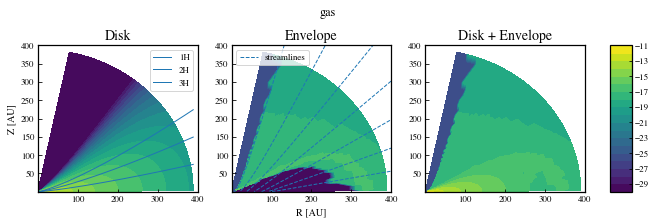

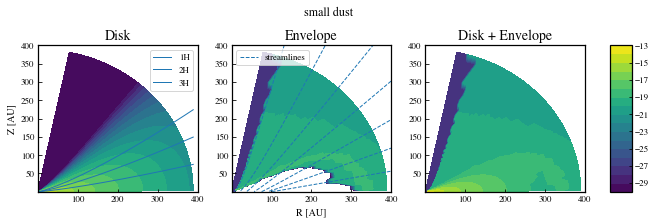

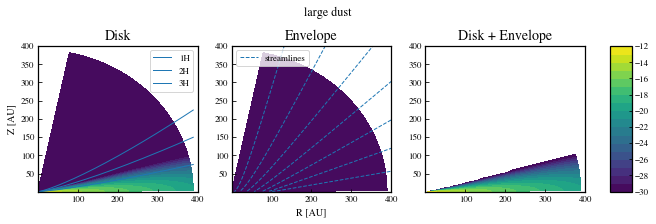

In [4]:
plot_components(d1,0)#gas
plot_components(d1,1)#small dust
plot_components(d1,2)#large dust

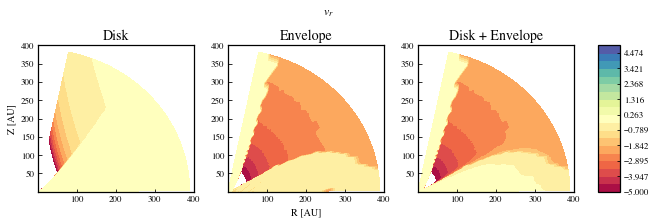

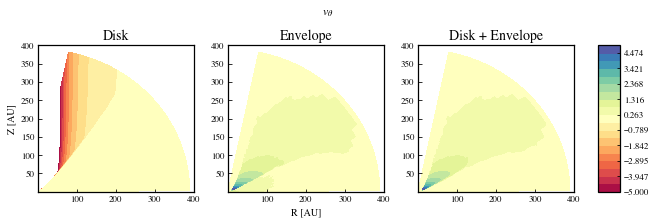

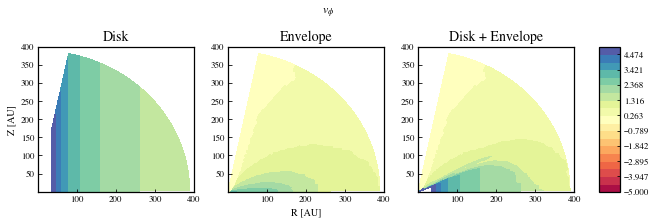

In [5]:
def plot_velocities(self,vector=0):
    f,ax= subplots(1,3,constrained_layout=True)
    vectors = [r'$v_r$',r'$v_{\theta}$', r'$v_{\phi}$']
    keys = ['r','theta','phi']
    f.suptitle(vectors[vector])
    f.set_size_inches(9,3)
    components = {'Disk': self.v_disk(),'Envelope': self.v_env(), 'Disk + Envelope': self.v_embedded()}
    for a,c in zip(ax, components.keys()):
        sca(a)
        vfield = components[c][keys[vector]]
        im=plot_slice(self,rho=vfield/1e5,log=False,plot_params={'levels':np.linspace(-5,5,20),'cmap':'Spectral'})
        a.set_title(c,fontsize=14)
        a.set_xlim(self.grid['min'][0],self.grid['max'][0])
        a.set_ylim(a.get_xlim())
    colorbar(im,ax=ax)
    ax[1].set_xlabel('R [AU]')
    ax[0].set_ylabel('Z [AU]')
    
plot_velocities(d1,0)
plot_velocities(d1,1)
plot_velocities(d1,2)

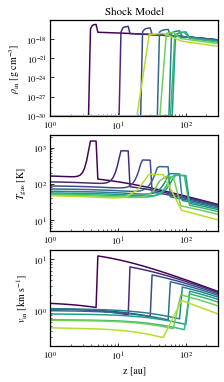

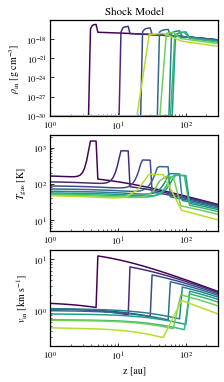

In [6]:
plot_shock_model(d1)

### Do the thermal radiative transfer for the dust

*Files for radmc*: you can put in your own files if you have them, or use the functions in ```write_inputs.py``` to write them
+ amr_grid.inp: ```write_grid``` *writes grid for mirror symmetry in spherical coordinates*
+ dust_density.inp: ```write_dust_density``` *writes dust density based on sum of all three model components*
+ dustkappa_...inp: nothing yet
+ dustopac.inp: nothing yet
+ wavelength_micron.inp: ```write_wavelength``` *copies template file in models directory*
+ stars.inp: ```write_star``` *copies template file in models directory, swaps out temperature*
+ external_source.inp: ```calc_ISRF``` *scales ISRF from Mathis ISRF file in models directory according to input G0*

*after you have all the files in the model directory*

you can call the```out ``` class defined in ```outputs.py``` to get access to the grids and run radmc3d functions on it

or run radmc3d from the command line. (calling the object will let you access the results from the model itself) 

In [7]:
write_grid(d1)
write_dust_density(d1)
write_star(d1)
write_viscous_heatsource(d1)
#write_main(d1)
#calc_ISRF(d1)

Reading wavelength_micron.inp
Writing stars.inp
Reading amr_grid.inp
Reading wavelength_micron.inp


Reading amr_grid.inp
Reading wavelength_micron.inp
{'lnu_star': array([8.62927658e+33]), 'lnu_accdisk': 1.5098729260652315e+33, 'lnu_spot': 1.5098729260652315e+33}


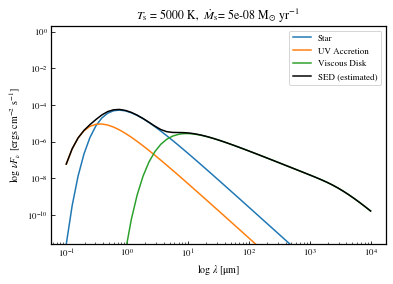

In [8]:
plot_flux_components(d1)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


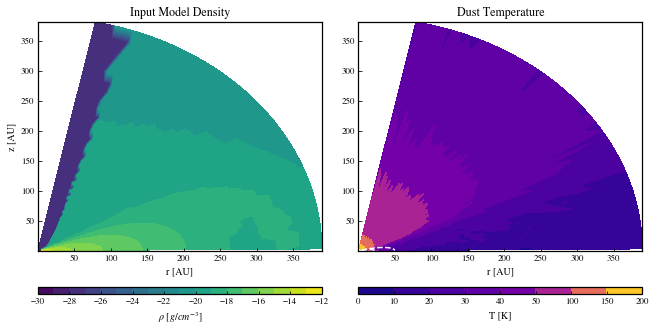

In [9]:
m1 = out(d1)
m1.thermal_RT()
plot_dustRT(d1)


### Make some images (if you want)

In [10]:
rpy.image.makeImage(npix=400., wav=2100, incl=90, phi=0, sizeau=600.)



Executing RADMC-3D Command:
radmc3d image npix 400 incl 90 sizeau 600.0 lambda 2100 phi 0 pointau 0.0  0.0  0.0 fluxcons


0

Reading image.out


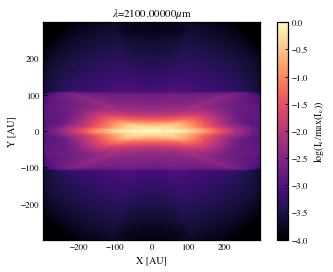

{'implot': <matplotlib.image.AxesImage at 0x7fc3b1b08e80>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fc3ae658580>}

In [11]:
im = rpy.image.readImage(binary=False)
rpy.image.plotImage(im, au=True, log=True, maxlog=4, saturate=1, cmap=cm.magma)

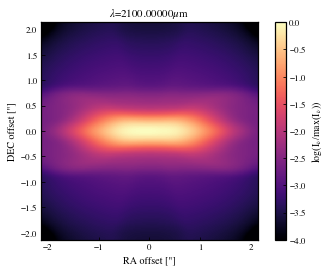

{'implot': <matplotlib.image.AxesImage at 0x7fc3b3f63790>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fc3b19c4e50>}

In [12]:
cim = im.imConv(fwhm=[0.2, 0.2], pa=0., dpc=140.)
rpy.image.plotImage(cim, arcsec=True, dpc=140., log=True, maxlog=4, cmap=cm.magma)

### Compute Radiation Fields


### Make your new grid for the chemistry

In [5]:
write_out(d1)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


/Users/aleksandra/Desktop/wedgeford/models/make_model.py:160: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))


Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


'model.out'

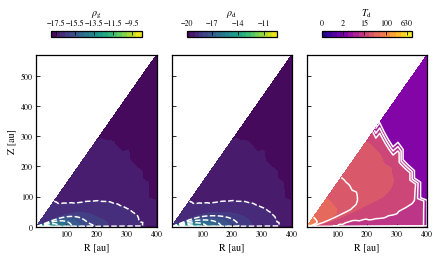

In [20]:
f, ax = subplots(1,3,constrained_layout=True)
f.set_size_inches((6,3.5))
grid = False
os.chdir(d1.outdir)
for col,prop,cmap,label in zip(ax,['rhog','rhod','Td'],['viridis','viridis','plasma'],[r'$\rho_{\rm g}$',r'$\rho_{\rm d}$',r'$T_{\rm d}$']):
    sca(col)
    plot_out(prop=prop,cmap=cmap,levels=20)
    cbar = colorbar(ax=col,location='top',shrink=0.75,aspect=8,label=label)
    if prop == 'Td':
        cbar.set_ticks(cbar.get_ticks()[::2])
        cbar.set_ticklabels((10**np.array(cbar.get_ticks())).astype(int).astype(str))
    else:
        cbar.set_ticks(cbar.get_ticks()[::2])
    plot_out(prop=prop,method=contour,colors='white',levels=10)
    axis('scaled')
    xlabel('R [au]')
    if col == ax[0]:
        ylabel('Z [au]')
    else:
        col.yaxis.set_major_formatter(NullFormatter())
    d2 = read_out()
    if grid == True:
        plot(d2['r'].flatten(),d2['z'].flatten(),'w,',alpha=0.5) #grid points
    
            

In [61]:
uvfiletest = '../highenergy_RT/uv_photons_0.03Mslg_0.5m_0.1dg_uv_e1.dat'
def Tgas_from_UV(outname='model.out',uvfile='uv_photons.dat'):
    data = read_out(outname)
    n_points = len(data['r'].flatten())
    n_r = np.shape(data['rhod'])[0]
    n_z = np.shape(data['rhod'])[1]
    
    lvec = np.linspace(1,108,108)*10+920 #wavelength (Angstroms)
    evec = h*c/(lvec*1e-8) #energy
    
    all_flux = np.zeros((n_r,n_z))
    n_rchunk = 111 
    
    def integrate_spectrum(photons):
        evec2d = np.tile(evec,(np.shape(photons)[-1],1)).T
        integral = np.trapz(photons*evec2d,x=lvec,axis=0)/G0 #in units of Habings
        return integral
    
    for j in range(n_r):
        spectra = np.genfromtxt(uvfile,skip_header=4+j*n_rchunk,max_rows=108)
        photons = spectra[:,1:]
        integral = integrate_spectrum(photons)
        all_flux[j,:] += integrate_spectrum(photons)
        
    NH2 = data['rhog']/(mu*mh) #gas density in n mol.
    NH = 2.0*NH2 # gas density in n atom
    x = np.log10(NH/1e5)
    x[x>9.2920]=9.29199  # Max density where this works is ~1e14 cm^-3.

    all_flux = np.clip(all_flux, a_min=0, a_max=None)
    delT = 420.2*(all_flux/1e3)**(1.05-0.113*x)*1.0/(10**(0.486*x-0.014*x**2)) # change in temperature based on integral
    delT[NH<1e-2] = 0.0 #set to 0 for threshhold low density
    
    data['Tg'] = np.clip(data['Td']+delT,a_min=None,a_max= 4200.) #modify calculated T diff from dust T
    return data
        
#Tgas_from_UV(uvfile=uvfiletest)


In [33]:
def cosmic_ray_zeta(outname = 'model.out',cr_model='m02'):
    data = read_out(outname)
    def zetaeval(ncol,model=cr_model):
        labels = ['m02','w98','ssm','ssx','ttm','ttx']
        #Rates from Cleeves et al. 2014
        #zeta_powerlaw alpha zeta_exponential Sigma
        allrts = np.array([[6.8e-16,3.7e-18,0.423,210.0],
            [2.0e-17,9.4e-19,0.021,260.0],
            [1.1e-18,3.0e-19,-0.00,260.0],
            [1.6e-19,7.5e-20,-0.01,250.0],
            [7.0e-21,4e-21,-0.01,290.0],
            [1.1e-22,3e-23,-0.02,490.0]])

        modin = labels.index(model)
        zp = allrts[modin,0]
        ze = allrts[modin,1]
        al = allrts[modin,2]
        co = allrts[modin,3]
        mumult = 2.36
        piv = 1e20
        F = zp*ze*mumult/(ze*mumult*(ncol/piv)**al+zp*(exp(ncol*2.0*mh/co)-1)) #C13 eq5
        return F
    
    Ncol_external = 1e10 #column before disk surface
    
    rhog = data['rhog']
    axis = 1
    rpts = np.unique(data['r'])
    zmin = 1e-10
    zc = data['z']
    dzz = 0.18741465494412662 #delta z/z for 50 bins 
    dz = zc*dzz*AU
    rhog_los = np.append(np.flip(rhog,axis=axis),rhog,axis=axis)
    dz_los = np.append(np.flip(dz,axis=axis),dz,axis=axis)
    Ncol_zpos = np.cumsum(rhog_los*dz_los,axis=axis)/(mu*mh) + Ncol_external
    Ncol_zneg = np.cumsum(np.flip(rhog_los*dz_los,axis=axis),axis=axis)/(mu*mh) + Ncol_external
    zeta = 0.5*zetaeval(Ncol_zpos,model=cr_model) + 0.5*zetaeval(Ncol_zneg,model=cr_model)
    data['zeta'] = zeta[:,:50]
    return data

cosmic_ray_zeta()

{'r': array([[1.000000e-01, 1.000000e-01, 1.000000e-01, ..., 1.000000e-01,
         1.000000e-01, 1.000000e-01],
        [1.057000e-01, 1.057000e-01, 1.057000e-01, ..., 1.057000e-01,
         1.057000e-01, 1.057000e-01],
        [1.118000e-01, 1.118000e-01, 1.118000e-01, ..., 1.118000e-01,
         1.118000e-01, 1.118000e-01],
        ...,
        [3.578576e+02, 3.578576e+02, 3.578576e+02, ..., 3.578576e+02,
         3.578576e+02, 3.578576e+02],
        [3.783425e+02, 3.783425e+02, 3.783425e+02, ..., 3.783425e+02,
         3.783425e+02, 3.783425e+02],
        [4.000000e+02, 4.000000e+02, 4.000000e+02, ..., 4.000000e+02,
         4.000000e+02, 4.000000e+02]]),
 'z': array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 8.970000e-02,
         1.082000e-01, 1.306000e-01],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.480000e-02,
         1.144000e-01, 1.381000e-01],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.002000e-01,
         1.209000e-01, 1.460000e-01],
   

In [ ]:
#################################################################################
def Create_0io(dir,runnm,uv,xr,isrf,slr,st,rre,rsp,ioname):

    finp = dir+'/environ/'+runnm+'/'+ioname
    fi = open(finp,'w')
    fi.write('# input & output files:\n')
    fi.write('{:<45}'.format(rsp)+'# file with species\n')
    fi.write('{:<45}'.format(rre)+'# file with reactions\n')
    fi.write('{:<45}'.format(uv)+'# file with uvfield\n')
    fi.write('{:<45}'.format(xr)+'# file with xrfield\n')
    fi.write('{:<45}'.format(isrf)+'# file with ISRF\n')
    fi.write('{:<45}'.format(slr)+'# Radionuclide Ion Rate\n')
    fi.write('{:<45}'.format(st)+'# 2D abundance file ending\n')
    fi.close()

    for file in os.listdir(dir+'/environ/'):
        if fnmatch.fnmatch(file,runnm+'*'):
            foundfile = file
            if file != runnm:
                shutil.copy2(finp,dir+'/environ/'+foundfile+'/'+ioname)

    return


In [10]:
if not os.path.exists(outdir):
		os.makedirs(outdir)
zetacr = 1.3e-17
	for n in range(len(r)): #write a new file for each radius?
		#outfile = open(outdir+'1environ.inp.e1.'+np.round(r[n],decimals=4))
		#outfile.write('  R             rho           Tgas          Tdust        zAU           zcm           Nrz           ZetaCR        DustFrac\n')
		#outfile.write('1\n')
		#outfile.write(str(nz)+'\n')
		if n !=0 and r[n] == r[n-1]:
			nsig_unset = -3.0 *rhog[n] * dust2gas/rho_si * (amax_ism**-0.5 - amin_chem**-0.5)/ \
			(amax_ism**-0.5 - amin_chem**-0.5)
			nsig_tot = 0.0
			for d in range(ndust):
				nsig = -3.0 *rhod[d,n]/rho_si * (amax[d]**-0.5 - amin[d]**-0.5)/ \
				(amax[d]**-0.5 - amin[d]**-0.5)
				nsig_tot = nsig_tot + nsig
			dustfrac = nsig_tot/nsig_unset
			zcm = zcm + np.abs(z[n]-z[n-1])
		else:
			zcm = 1e-10
			print("new radius:",r[n],z[n])
            
    #outfile.write(' %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E\n'%(r[n],rhod[n],Td[n],Td[n],z[n],zcm,1e10,zetacr,dustfrac))

In [ ]:
isrf_model = 'isrf_'+isrf_vals[i]+'_half_'+env_orig[e]+'.dat'
isrf_model = 'None'
ioname = '0io.'+str(int(float(isrf_vals[i])))+'G0.x'+str(int(float(xr_vals[x])))+'.inp'
#print(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Tgas_Comp(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Generate_Environment(diskchem_dir,env_orig[e])
Create_0io(diskchem_dir,env_orig[e],uv_model[e],xr_model,isrf_model,slr_model[e],srt_time[e],rreac,rspec,ioname)